In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [2]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

convert_tensor = transforms.ToTensor()
resize_to_300 = transforms.Resize((300,300))

In [4]:
music_data = {}
keys = ['ambient', 'symphonic', 'country', 'rocknroll','metal' ]
for key in keys:
    music_data[key] = {}
for genre in os.listdir('./Stimuli/'):
    for file in os.listdir('./Stimuli/'+ genre):
        if 'spec' in file:
            path = './Stimuli/'+ genre +'/' + file
            img = convert_tensor(np.array(Image.open(path).convert('L'))[50:450, 100:500])
            spec = img[0]
            music_data[genre][file[0]] = spec


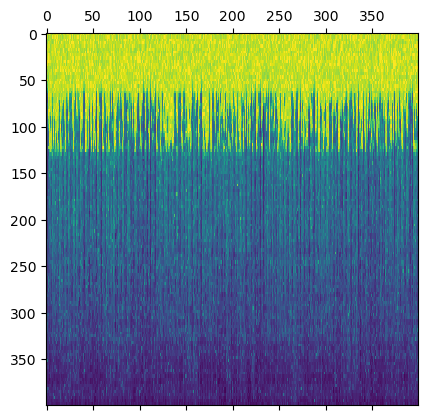

In [5]:
plt.matshow(spec)

In [6]:
inp = torch.rand(10,1,160,160,36)

In [7]:
inp.view(inp.shape[0],-1).shape

torch.Size([10, 921600])

In [8]:
conv1 = nn.Sequential(
                nn.Conv3d(1, 4, kernel_size=(7, 7, 7), padding=3),
                nn.ReLU(),
                nn.MaxPool3d((4, 4, 4)),
                )
conv2 = nn.Sequential(
                nn.Conv3d(4, 4, kernel_size=(5, 5, 5), padding=2),
                nn.ReLU(),
                nn.MaxPool3d((2, 2, 2)),
                )
conv3 = nn.Sequential(
                nn.Conv3d(4, 1, kernel_size=(3, 3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool3d((2, 2, 2)),
                )


In [9]:
print(inp.shape)
out = conv1(inp)
print(out.shape)
out = conv2(out)
print(out.shape)
out = conv3(out)
print(out.shape)
print(out[1][0][0])
out = out.view(out.shape[0], -1)
print(out.shape)

torch.Size([10, 1, 160, 160, 36])
torch.Size([10, 4, 40, 40, 9])
torch.Size([10, 4, 20, 20, 4])
torch.Size([10, 1, 10, 10, 2])
tensor([[0.0418, 0.0000],
        [0.0661, 0.0333],
        [0.0546, 0.0139],
        [0.0477, 0.0252],
        [0.0477, 0.0368],
        [0.0593, 0.0325],
        [0.0481, 0.0390],
        [0.0623, 0.0340],
        [0.0492, 0.0383],
        [0.0445, 0.0447]], grad_fn=<SelectBackward0>)
torch.Size([10, 200])


In [10]:
out = out.view(out.shape[0], 1, 10, 10, 2)
print(out.shape)

torch.Size([10, 1, 10, 10, 2])


In [11]:
deconv1 = nn.Sequential(nn.ConvTranspose3d(1, 4, kernel_size= (3,3,3), padding=1),
                       nn.Upsample(size=(20,20,4)))

deconv2 = nn.Sequential(nn.ConvTranspose3d(4, 4, kernel_size= (5,5,5), padding=2),
                       nn.Upsample(size=(40,40,9)))

deconv3 = nn.Sequential(nn.ConvTranspose3d(4, 1, kernel_size= (7,7,7), padding=3),
                       nn.Upsample(size=(160,160,36)))

In [12]:
out = deconv1(out)
print(out.shape)
out = deconv2(out)
print(out.shape)
out = deconv3(out)
print(out.shape)

torch.Size([10, 4, 20, 20, 4])
torch.Size([10, 4, 40, 40, 9])
torch.Size([10, 1, 160, 160, 36])


In [13]:
class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        
        self.conv1 = nn.Sequential(
                nn.Conv3d(1, 16, kernel_size=(7, 7, 7), padding=1),
                nn.ReLU(),
                nn.MaxPool3d((4, 4, 4)),
                )
        self.conv2 = nn.Sequential(
                nn.Conv3d(16, 4, kernel_size=(5, 5, 5), padding=1),
                nn.ReLU(),
                nn.MaxPool3d((4, 4, 4)),
                )
        
        self.fc1 = nn.Linear(324, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
    

    def forward(self, x):
        # Set 1
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

In [14]:
num_classes = 5

class CNN_Enc_Dec(nn.Module):
    def __init__(self):
        super(CNN_Enc_Dec, self).__init__()
        
        self.model = model =  ViT(
                    patch_size=100, 
                    num_layers=3, 
                    h_dim=512, 
                    num_heads=7, 
                    num_classes=200, 
                    d_ff=1024, 
                    max_time_steps=1000, 
                    use_clf_token=True,
                    dropout=0.1,
                    dropout_emb=0.1,
                    channels=1
                )
     
        self.deconv1 = nn.Sequential(nn.ConvTranspose3d(1, 4, kernel_size= (3,3,3), padding=1),
                       nn.Upsample(size=(20,20,4)))

        self.deconv2 = nn.Sequential(nn.ConvTranspose3d(4, 4, kernel_size= (5,5,5), padding=2),
                       nn.Upsample(size=(40,40,9)))

        self.deconv3 = nn.Sequential(nn.ConvTranspose3d(4, 1, kernel_size= (7,7,7), padding=3),
                       nn.Upsample(size=(160,160,36)))
        
        self.classifier = CNN_Classifier()

    def forward(self, x):
        # Set 1
        out = self.model(x)
        out = out.view(out.shape[0], 1, 10, 10, 2 )
        out = self.deconv1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        out = self.classifier(out)
        return out

In [15]:
# !pip install pytorch-lightning

In [16]:
from models.vit import ViT

In [17]:
inp = torch.rand(10,1,300,300)

In [18]:
model = CNN_Enc_Dec()
out = model(inp)
print(out.shape)

torch.Size([10, 5])


In [19]:
inp.type()

'torch.FloatTensor'

In [20]:
from models.vit import ViT

In [21]:
import os
import nibabel as nib
import pandas as pd

dirname = 'ds000113b_R2.0.1/'
brain_volumes = []
class_labels = []
music = []
classes = ['ambient', 'symphonic', 'country', 'rocknroll','metal' ]
for subj in os.listdir(dirname):
    for run in range(1,9):
        path = dirname+"/"+subj+"/func" + "/" + subj + '_task-auditoryperception_run-0'+ str(run)                     
        img = nib.load(path + '_bold.nii.gz')
        data = img.get_fdata()

        df = pd.read_csv(path + '_events.tsv', sep='\t')
        genres = df['genre'].values
        run_volumes = df['run_volume'].values
        stimuli = df['stim'].values
        for start, genre, stim in zip(run_volumes, genres, stimuli):
            volume = data[:,:,:,start:start+6].mean(axis=-1)
            brain_volumes.append(volume)
            class_labels.append(classes.index(genre))
            music.append(music_data[genre][stim[-5]])
#     break

In [22]:
len(brain_volumes), len(class_labels)

(600, 600)

In [23]:
music

[tensor([[0.8118, 0.7922, 0.8118,  ..., 0.8118, 0.8784, 0.8118],
         [0.8118, 0.7922, 0.8118,  ..., 0.8118, 0.8784, 0.8118],
         [0.8392, 0.8392, 0.7765,  ..., 0.7922, 0.8314, 0.8118],
         ...,
         [0.2431, 0.2627, 0.2510,  ..., 0.2392, 0.2549, 0.2510],
         [0.2431, 0.2627, 0.2510,  ..., 0.2392, 0.2549, 0.2510],
         [0.2431, 0.2627, 0.2510,  ..., 0.2392, 0.2549, 0.2510]]),
 tensor([[0.8118, 0.8392, 0.8784,  ..., 0.8392, 0.8039, 0.8588],
         [0.8118, 0.8392, 0.8784,  ..., 0.8392, 0.8039, 0.8588],
         [0.8039, 0.8784, 0.8510,  ..., 0.8392, 0.8039, 0.7843],
         ...,
         [0.2431, 0.2392, 0.2863,  ..., 0.2471, 0.2392, 0.2431],
         [0.2431, 0.2392, 0.2863,  ..., 0.2471, 0.2392, 0.2431],
         [0.2431, 0.2392, 0.2863,  ..., 0.2471, 0.2392, 0.2431]]),
 tensor([[0.8510, 0.8510, 0.7765,  ..., 0.7765, 0.8118, 0.8784],
         [0.8510, 0.8510, 0.7765,  ..., 0.7765, 0.8118, 0.8784],
         [0.7765, 0.8196, 0.7647,  ..., 0.7922, 0.8196, 0.

In [24]:
brain_volumes[0].shape

(160, 160, 36)

In [25]:
# import matplotlib.pyplot as plt
# a = brain_volumes[0]
# plt.imshow(a[:,:,18].T, cmap='Greys_r')
# print(data.shape)

In [26]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np

class BrainDataset(Dataset):
    def __init__(self, brain_volumes, class_labels, music):
        self.brain_volumes = brain_volumes
        self.class_labels = class_labels
        self.music = music

    def __len__(self):
        return len(self.class_labels)

    def __getitem__(self, idx):
        temp_img = brain_volumes[idx]
        ind = np.where(brain_volumes[idx] < 200)
        temp_img[ind] = 0
        temp_img = temp_img / 2200
        return temp_img, self.class_labels[idx], music[idx]


In [27]:
# train_len = int(0.8 * len(brain_volumes))
# train_dataset = BrainDataset(brain_volumes[:train_len], class_labels[:train_len])
# val_dataset = BrainDataset(brain_volumes[train_len:], class_labels[train_len:])

dataset = BrainDataset(brain_volumes, class_labels, music)

In [28]:
train_dataset , val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [29]:
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24)

In [30]:
for i, data in enumerate(train_loader):
    print(data[0].shape)
    print(data[1].shape)
    print(data[2].shape)
    break

torch.Size([24, 160, 160, 36])
torch.Size([24])
torch.Size([24, 400, 400])


In [31]:
def train_one_epoch(model, optimizer, dataloader,epoch):
    model.train()
    losses = []
    accs = []
    binaccs = []
    
    for i, (brain_volume, label, music) in enumerate(dataloader):
        optimizer.zero_grad()
        brain_volume = brain_volume.unsqueeze(1)
        
        music = music.unsqueeze(1)
        music = music.to(device)
        brain_volume = brain_volume.to(device)
        label = label.to(device)
        
        
        pred = model(music)
        
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        pred_labels = torch.argmax(pred, axis=1)
        
        acc = (pred_labels == label).sum() / len(label)
        accs.append(acc.item())
        
        pred_labels[pred_labels <=1] = 0
        pred_labels[pred_labels > 1] = 1
        label[label <=1 ]= 0 
        label[label > 1] = 1
        
        binacc = (pred_labels == label).sum() / len(label)
        binaccs.append( binacc.item() )
        
        print("Epoch ", epoch,": ", i, "/", len(dataloader), "loss :", loss.item(), "Acc :",acc , end='\r')
    print("train acc", np.mean(accs))
    print("train binary acc", np.mean(binaccs))
    return np.mean(losses), np.mean(accs)


def validate(model, optimizer, dataloader,epoch):
    model.eval()
    losses = []
    accs = []
    binaccs = []
    for i, (brain_volume, label, music) in enumerate(dataloader):
        brain_volume = brain_volume.unsqueeze(1)
        
        music = music.unsqueeze(1)
        music = music.to(device)
        brain_volume = brain_volume.to(device)
        label = label.to(device)
         
        pred = model(music)
        loss = loss_fn(pred, label)

        pred_labels = torch.argmax(pred, axis=1)
        
        acc = (pred_labels == label).sum() / len(label)
        accs.append(acc.item())
        
        losses.append(loss.item())
        
        pred_labels[pred_labels <=1] = 0
        pred_labels[pred_labels > 1] = 1
        label[label <=1 ]= 0 
        label[label > 1] = 1
        binacc = (pred_labels == label).sum() / len(label)
        binaccs.append( binacc.item() )
        
    print("val acc", np.mean(accs))
    print("val binary acc", np.mean(binaccs))
    
    return np.mean(losses), np.mean(accs)

In [32]:
model = CNN_Enc_Dec()
device = torch.device('cuda')
model.to(device)
# model.double()

# loss_fn = nn.CrossEntropyLoss()
def loss_fn(out, target):
    return torch.mean((out.view(out.shape[0], -1) - target.view(target.shape[0], -1))**2)

lr = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
num_epochs = 50
train_losses = []
val_losses = []
val_accs = []
train_accs = []
for epoch in range(num_epochs):
    loss, acc = train_one_epoch(model, optimizer, train_loader, epoch)
    val_loss, val_acc = validate(model, optimizer, val_loader, epoch)
    train_losses.append(loss)
    train_accs.append(acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print("---------------")

train acc 0.20208333916962146981348037719727 Acc : tensor(0.2083, device='cuda:0'))
train binary acc 0.5770833507180214
val acc 0.15833333730697632
val binary acc 0.550000011920929
---------------
train acc 0.16666667051613332232663154602051 Acc : tensor(0.0833, device='cuda:0')
train binary acc 0.48541667461395266
val acc 0.15833333730697632
val binary acc 0.550000011920929
---------------
train acc 0.1729166716337204.695063591003418 Acc : tensor(0.2083, device='cuda:0'))
train binary acc 0.5208333492279053
val acc 0.21666667461395264
val binary acc 0.7166666865348816
---------------
train acc 0.21458333861082793204008102416992 Acc : tensor(0.2917, device='cuda:0'))
train binary acc 0.5729166835546493
val acc 0.0666666679084301
val binary acc 0.550000011920929
---------------
train acc 0.22708334289491178965684413909912 Acc : tensor(0.2083, device='cuda:0'))
train binary acc 0.5729166850447655
val acc 0.15833333730697632
val binary acc 0.550000011920929
---------------
train acc 0.193

train acc 0.20208333842456343.987966537475586 Acc : tensor(0.2083, device='cuda:0'))
train binary acc 0.5520833492279053
val acc 0.15833333730697632
val binary acc 0.7083333492279053
---------------
train acc 0.19791667107492686.083040237426758 Acc : tensor(0.1250, device='cuda:0'))
train binary acc 0.5500000193715096
val acc 0.09166666865348816
val binary acc 0.5166666746139527
---------------
train acc 0.218750006146729 4.507895469665527 Acc : tensor(0.2083, device='cuda:0'))
train binary acc 0.5354166820645332
val acc 0.10000000074505806
val binary acc 0.1916666731238365
---------------
train acc 0.18750000353902584.378744602203369 Acc : tensor(0.2083, device='cuda:0'))
train binary acc 0.4979166805744171
val acc 0.21666667461395264
val binary acc 0.25000000596046446
---------------
train acc 0.22708334140479564.469342231750488 Acc : tensor(0.0833, device='cuda:0'))
train binary acc 0.5437500163912773
val acc 0.15000000447034836
val binary acc 0.5333333492279053
---------------
trai

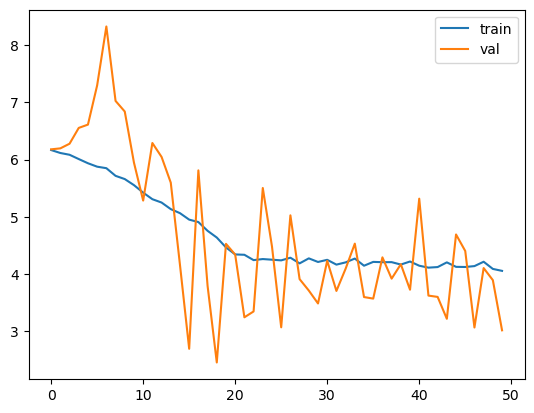

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()

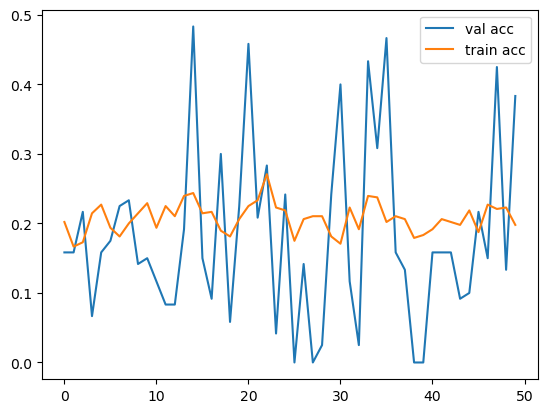

In [34]:
plt.plot(val_accs, label="val acc")
plt.plot(train_accs, label="train acc")
plt.legend()